# Notebook 4: (Demo) Co-registration of H&E with iQID dose-rate images
Inputs:
- H&E image
- iQID central-slice dose-rate image or dose-rate stack
- optional: cv2 contours showing hotspots on iQID dose-rate image

Outputs:
- transformation matrix to transform dose-rate image onto H&E image
- optional: cv2 contours overlaid on H&E image

Please note that certain procedures like transform.rotate operate in-place, so for best results always re-start and run the entire kernel.

In [1]:
# Move the working directory up one level to the one shown to find the source packages.
# Feel free to modify your own system path to accomodate this package if desired.
# Please note this change for all relative paths contained in the notebook.

In [2]:
cd ..

C:\Users\Robin\Documents\Cal\iQID\git_iqid_alphas


In [3]:
import os
import sys
import time
import numpy as np
from matplotlib import pyplot as plt
from skimage import transform, io, img_as_uint, util, color
from skimage.measure import block_reduce

import cv2
from pystackreg import StackReg

from importlib import reload
from iqid import align
reload(align)

<module 'iqid.align' from 'C:\\Users\\Robin\\Documents\\Cal\\iQID\\git_iqid_alphas\\iqid\\align.py'>

In [4]:
# Figure parameters
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

pltmap = plt.get_cmap("tab10")
testmap = plt.get_cmap("Set1")

GREEN = (36, 255, 12)
YELLOW = (255, 255, 0)

In [5]:
# Processing parameters and scale (FoV) data
downsample = 20
px, mm, subpx, ref_px_mm = np.genfromtxt(os.path.join('parameters', 'scale_data.csv'),
                            delimiter=',', skip_header=1,
                            usecols=(1,2,3,4), unpack=True)
mov_px_mm = px/mm * subpx
s_mov_px_mm = mov_px_mm[2]
s_ref_px_mm = ref_px_mm[2]

# Flag to permit affine distortion for registration; otherwise, use scaled rotation
affine = True

TiffPage 0: IndexError: tuple index out of range


loading: data\H700\25March


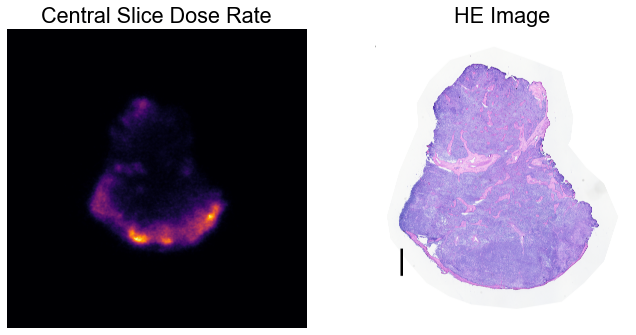

In [6]:
imdir = os.path.join('data', 'H700', '25March')

print('loading:', imdir)
t1 = time.time()

# 1. load dose image, masks, and HE reference
dosestack = io.imread(os.path.join(imdir, 'doseinfo', 'dosestack_mgy_per_hr.tif'))
central_slice = dosestack[len(dosestack)//2,:,:]

ref = io.imread(os.path.join(imdir, 'HE', 'HE.tif'))

# masks from histogram segmentation; optional
midmask = io.imread(os.path.join(imdir, 'mask', '1sig_mask.png'))
hotmask = io.imread(os.path.join(imdir, 'mask', '2sig_mask.png'))

# 1. (visualization)
f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(central_slice, cmap='inferno')
ax[0].set_title('Central Slice Dose Rate')
ax[1].imshow(ref)
ax[1].set_title('HE Image')
ax[0].axis('off')
ax[1].axis('off')
plt.tight_layout()
plt.show()

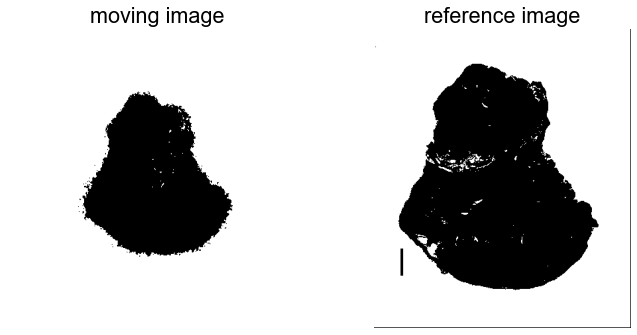

In [7]:
# 2. downsample HE reference to reduce computation
ds_array = ref/255

r = block_reduce(ds_array[:, :, 0], (downsample, downsample), np.mean)
g = block_reduce(ds_array[:, :, 1], (downsample, downsample), np.mean)
b = block_reduce(ds_array[:, :, 2], (downsample, downsample), np.mean)
ds_array = np.stack((r, g, b), axis=-1)

# 3. create binaries and apply mirroring if needed    
refmask = align.binary_mask(color.rgb2gray(ds_array), finagle=1)
movmask = util.invert(align.binary_mask(central_slice, finagle=0.1))

# 3. (visualization)
f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(movmask, cmap='gray') 
ax[0].set_title('moving image')
ax[1].imshow(refmask, cmap='gray')
ax[1].set_title('reference image')
ax[0].axis('off')
ax[1].axis('off')
plt.tight_layout()
plt.show()

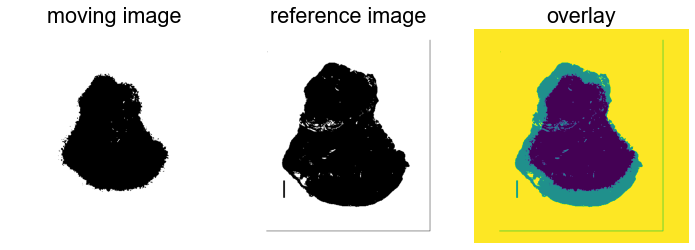

In [8]:
# 4. pad binaries to same size
fac = s_ref_px_mm/downsample /s_mov_px_mm

scaled_mov = transform.rescale(movmask, fac)
movpad, refpad = align.pad_2d_masks(scaled_mov, refmask)

check = align.overlay_images([movpad, refpad])

# 4. (visualization)
f, ax = plt.subplots(1, 3, figsize=(10, 7))
ax[0].imshow(movpad, cmap='gray')
ax[0].set_title('moving image')
ax[1].imshow(refpad, cmap='gray') 
ax[1].set_title('reference image')
ax[2].imshow(check)
ax[2].set_title('overlay')
for j in range(3):
    ax[j].axis('off')
plt.tight_layout()
plt.show()   

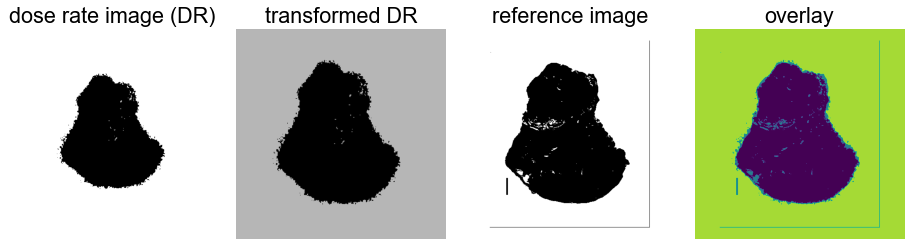

In [9]:
# 5. align binaries
movrot, outdeg = align.coarse_rotation(movpad, refpad, deg=2)

if affine:
    sr = StackReg(StackReg.AFFINE)
else:
    sr = StackReg(StackReg.SCALED_ROTATION)

reg = sr.register_transform(refpad, movrot)
reg = reg.clip(min=0)

# 5. (visualization)
check = align.overlay_images([reg, refpad])
f, ax = plt.subplots(1, 4, figsize=(13, 7))
ax[0].imshow(movrot, cmap='gray')
ax[0].set_title('dose rate image (DR)')
ax[1].imshow(reg, cmap='gray')
ax[1].set_title('transformed DR')
ax[2].imshow(refpad, cmap='gray') 
ax[2].set_title('reference image')
ax[3].imshow(check)
ax[3].set_title('overlay')
for j in range(4):
    ax[j].axis('off')
plt.tight_layout()
plt.show()

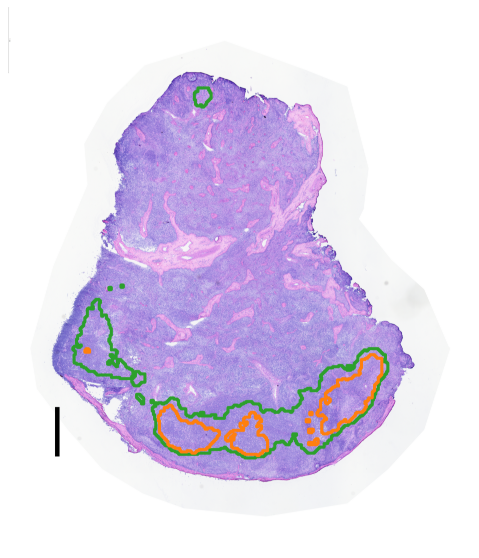

Done in 23.90 s


In [10]:
# 6. get the transformation matrix between aligned binaries
tmat = sr.get_matrix()
tf = transform.AffineTransform(matrix=tmat)

# optional: see masks from hist
# perform same transformation on the masks derived from dose rate image contours (data analysis)
hifac = fac * downsample

scaled_1 = transform.rescale(midmask, fac)
rot_mask = transform.rotate(scaled_1, outdeg)
warp_mask = transform.warp(rot_mask, tf)
warp_mask = np.round(warp_mask.clip(min=0))
scaled_mask = transform.rescale(warp_mask, downsample)

r = ref.copy()
reg_midmask, _ = align.pad_rgb_im(scaled_mask, r)

scaled_1 = transform.rescale(hotmask, fac)
rot_mask = transform.rotate(scaled_1, outdeg)
warp_mask = transform.warp(rot_mask, tf)
warp_mask = np.round(warp_mask.clip(min=0))
scaled_mask = transform.rescale(warp_mask, downsample)
reg_hotmask, cont_im = align.pad_rgb_im(scaled_mask, r)


cnts = cv2.findContours((reg_midmask*255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(cont_im, [c], -1, (np.array(pltmap(2))*255), thickness=50)

cnts = cv2.findContours((reg_hotmask*255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(cont_im, [c], -1, (np.array(pltmap(1))*255), thickness=50)

final = align.crop_down(cont_im, ref)

plt.figure(figsize=(20,10))
plt.imshow(final)
plt.axis('off')
plt.show()

print('Done in {:.2f} s'.format(time.time()-t1))